# Bank Bonus Churning Advisor: A Data-Driven Prototype for Optimizing Account Bonuses by Lana Bracken

*Applying data analytics, data management, software systems, and cybersecurity concepts to real-world personal finance.*


# About this Project: Bank Bonus Churning Advisor

This notebook presents the Capstone Project for the WTAMU MS-CISBA program.  
The project explores the emerging hobby of **bank account bonus churning** from a customer’s perspective, using data analytics, data management, software systems, and cybersecurity principles.

## Project Goals
- Build a prototype system to track and recommend bank account bonus offers based on user effort and preferences.
- Scrape real-world offer data from **Doctor of Credit** and structure it for analysis.
- Allow users to define personal effort tolerance and banking behaviors to guide recommendations.
- Visualize recommended bank bonuses in an actionable format.

## Technologies Used
- Python
- pandas (Data Management + Analysis)
- matplotlib (Data Visualization)
- IPython / Colab (Interactive Notebook Environment)
- Manual web scraping for data collection
- Gemini AI (Large Language Model prompting) was used to extract and structure bank bonus information from raw web content. This approach provided cleaner data than traditional scraping alone.


## 🎓 MS-CISBA Curriculum Connections
This project synthesizes learning across the program’s key domains:
- **Data Analytics:** Scoring and recommending offers based on defined metrics  
- **Data Management:** Cleaning and structuring scraped data for reliable analysis  
- **Software Systems:** Building an interactive prototype system with reusable code  
- **Networking & Cybersecurity:** Documenting personal data risks and mitigation strategies related to churning



# Data Collection (Scraping Data)

For this project, bank bonus data was primarily scraped from **Doctor of Credit** using a Python-based web scraper.  
The scraper pulled fields such as Bank Name, Offer Title, Bonus Amount, Requirements, and Links.  

In addition, I utilized LLM prompting with Gemini AI to extract structured bank bonus information from raw web content.  
This hybrid approach often provided cleaner data and reduced manual cleanup compared to scraping alone.

This step focuses on:
- Identifying the data source
- Extracting structured offer data
- Using Gemini to assist with prompt-based data extraction
- Saving the combined data into `DOC_Bank_Bonus_AI.csv` for further processing


In [2]:
# STEP 0: Install libraries
!pip install -q requests beautifulsoup4 pandas google-generativeai tqdm

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from tqdm import tqdm
import google.generativeai as genai
from datetime import datetime, timedelta
import json

# STEP 1: Configuration
# API Key Safety Notice
"""This prototype originally used an external API with a private API key.
For security, the API key and any live API calls have been commented out.
The remaining notebook functionality works fully without the API dependency.
"""

#api_key = ""  # Replace this with your Gemini API key
refresh_days = 7
save_file = "DOC_Bank_Bonus_AI.csv"
# top_n = 2 # Two banks
top_n = None # All banks

# STEP 2: Setup Gemini
#genai.configure(api_key=api_key)
#model = genai.GenerativeModel('gemini-1.5-pro-latest')

# STEP 3: Helper functions
def parse_bank_name(title):
    bank_match = re.match(r"^(.*?)(?:\$[\d,]+)", title)
    return bank_match.group(1).strip() if bank_match else title

def needs_scraping(last_scrape_str):
    if pd.isna(last_scrape_str) or last_scrape_str == '':
        return True
    try:
        last_scrape = datetime.strptime(last_scrape_str, "%Y-%m-%d %H:%M:%S")
        return datetime.now() - last_scrape > timedelta(days=refresh_days)
    except:
        return True

def extract_offer_glance(soup):
    data = {key.lower(): None for key in [
        "maximum bonus amount",
        "direct deposit required",
        "additional requirements",
        "hard/soft pull",
        "credit card funding",
        "monthly fees",
        "early account termination fee",
        "expiration date",
        "availability",
        "days to complete"
    ]}

    strong_tag = soup.find('strong', text='Offer at a glance')
    if strong_tag:
        ul = strong_tag.find_next('ul')
        if ul:
            for li in ul.find_all('li'):
                for tag in li.find_all(['s', 'del']):
                    tag.decompose()
                text = li.get_text()
                for key in data.keys():
                    if key in text.lower():
                        # Extract the value using regex
                        match = re.search(r':\s*(.+)', text)  # Find colon and capture what follows
                        if match:
                            data[key] = match.group(1).strip()  # Store the captured value (stripped)
                        else:
                            data[key] = text.strip() # If no colon, store the whole text
            return data
        else:
            print("  No UL found after strong tag")
    else:
        print("No strong tag found with 'Offer at a glance'")
    return data

def summarize_offer_with_gemini(text):
    prompt = f"""
You are a helpful assistant extracting structured data from messy bank bonus offer pages.
From the text below, extract and return this as a Python dictionary:
1. Bonus Total
2. Checking Bonus Requirements
3. Savings Bonus Requirements
4. Extra Bonus (if any)
5. Avoiding Fees (both checking and savings)
6. Early Termination Policy
7. Reviewer Verdict
8. Direct Link to Offer (if any)

Text to analyze:
{text}
    """
    response = model.generate_content(prompt)
    return response.text

import os

# STEP 4: Scrape main page
url = 'https://www.doctorofcredit.com/best-bank-account-bonuses/'
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

def get_full_post_link(ul):
    if ul:
        for a in ul.find_all('a', href=True):
            if 'read our ' in a.text.lower():
                return a['href']
    return None

records = []
toc = soup.select_one('#toc_container')
toc_links = toc.find_all('a') if toc else []
id_to_category = {}
current_category = None

for a in toc_links:
    href = a.get('href', '')
    if href.startswith('#'):
        anchor = href[1:]
        text = a.get_text(strip=True)
        if anchor and a.parent.name == 'li' and a.parent.find_parent('ul') and a.parent.find_parent('ul').get('class') == ['toc_list']:
            # main category (depth 1)
            current_category = text
        else:
            # sub-item
            id_to_category[anchor] = current_category

for h3 in soup.select('div.entry-content h3'):
    title = h3.get_text(strip=True)
    span = h3.find('span')
    anchor = span.get('id') if span else None
    category = id_to_category.get(anchor, 'Unknown')
    p = h3.find_next_sibling('p')
    ul = h3.find_next_sibling('ul')
    link = p.a['href'] if p and p.a else None
    full_post_link = get_full_post_link(ul)
    direct_offer_link = None
    if ul:
        for a in ul.find_all('a', href=True):
            if 'direct link to offer' in a.text.lower():
                direct_offer_link = a['href']

    records.append({
        'Bank Offer Title': title,
        'Bank Name': parse_bank_name(title),
        'Direct Link': link,
        'Direct Link to Offer': direct_offer_link,
            'Full Post Link': full_post_link,
            'Category': category,
            'Last Scraped Timestamp': '',
            'Last Scraped Status': ''
        })

df_new = pd.DataFrame(records)

# Load existing file if it exists
if os.path.exists(save_file):
    df_existing = pd.read_csv(save_file)
    # Only merge caching fields + Gemini output
    cache_cols = ['Full Post Link', 'Last Scraped Timestamp', 'Last Scraped Status',
                  'AI Structured Offer (Raw)', 'Bonus Total', 'Checking Bonus Requirements',
                  'Savings Bonus Requirements', 'Extra Bonus', 'Avoiding Fees',
                  'Early Termination Policy', 'Reviewer Verdict', 'Direct Link to Offer']
    df_existing = df_existing[[col for col in cache_cols if col in df_existing.columns]]
    df = pd.merge(df_new, df_existing, on='Full Post Link', how='left')

    # SAFETY: Ensure key tracking columns exist
    for col in ['Last Scraped Timestamp', 'Last Scraped Status']:
        if col not in df.columns:
            df[col] = ''
else:
    df = df_new.copy()
if top_n:
    df = df.head(top_n).copy()

# STEP 5: Process each row
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    if not needs_scraping(row['Last Scraped Timestamp']):
        df.at[index, 'Last Scraped Status'] = 'Skipped (recent)'
        continue

    try:
      post_url = row['Full Post Link']
      r = requests.get(post_url, headers=headers)
      soup_post = BeautifulSoup(r.content, 'html.parser')

      offer_glance = extract_offer_glance(soup_post)
      for key, value in offer_glance.items():
          df.at[index, key] = value

      content_div = soup_post.find('div', class_='entry-content')
      if content_div:
          for tag in content_div.find_all(['s', 'del']):
              tag.decompose()
          full_text = content_div.get_text(separator='\n').strip()
      else:
          full_text = ''

      df.at[index, 'Raw Post Text'] = full_text

      #ai_response = summarize_offer_with_gemini(full_text)
      # DO NOT PARSE AI RESPONSE
      # We only save full AI output. All fields come from scraping.
      #df.at[index, 'AI Structured Offer (Raw)'] = ai_response

      df.at[index, 'Last Scraped Timestamp'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
      df.at[index, 'Last Scraped Status'] = 'Success'

    except Exception as e:
        df.at[index, 'Last Scraped Status'] = f'Error: {e}'

df.to_csv(save_file, index=False)

print(f" Data saved to {save_file}")
df[['Bank Name','Bank Offer Title','Last Scraped Status']]


  0%|          | 0/162 [00:00<?, ?it/s]<ipython-input-2-0dfcbaace9be>:58: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  strong_tag = soup.find('strong', text='Offer at a glance')
  1%|          | 1/162 [00:00<01:09,  2.31it/s]<ipython-input-2-0dfcbaace9be>:58: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  strong_tag = soup.find('strong', text='Offer at a glance')
 10%|▉         | 16/162 [00:06<00:51,  2.85it/s]

No strong tag found with 'Offer at a glance'


 43%|████▎     | 69/162 [00:32<01:01,  1.52it/s]

No strong tag found with 'Offer at a glance'


100%|██████████| 162/162 [01:29<00:00,  1.80it/s]

 Data saved to DOC_Bank_Bonus_AI.csv


,Bank Name,Bank Offer Title,Last Scraped Status
0,Chase,Chase $900 Checking/Savings Bonus,Success
1,U.S. Bank,U.S. Bank $450 + $80 Checking Bonus,Success
2,Wells Fargo,"Wells Fargo $2,500 Premier Bonus",Success
3,First Tech Federal Credit Union,First Tech Federal Credit Union $300,Success
4,Chime,Chime $425 Portal Bonus,Success
...,...,...,...
157,"City National Bank VA, WV, OH, In Branch only –","City National Bank VA, WV, OH, In Branch only ...",Success
158,Expedition Credit Union,Expedition Credit Union $200 – MN,Error: Invalid URL 'None': No scheme supplied....
159,San Mateo Credit Union,San Mateo Credit Union $100 Bonus – Direct Dep...,Success
160,Green State Credit Union,Green State Credit Union $100 Checking Bonus –...,Success


#Data Cleaning

The scraped dataset contained inconsistencies and unstructured text.  
This section documents how `DOC_Bank_Bonus_AI.csv` was transformed into a clean, structured dataset (`DOC_Bank_Bonus_Cleaned.csv`) for analysis.

Cleaning steps included:
- Dropping unused and empty columns
- Standardizing column names and data formats
- Extracting key fields (Direct Deposit, Account Type, Effort Factors)
- Adding placeholders for manually populated fields (e.g., `MinDeposit`, `DebitTransactionRequirement`)
- Preparing the dataset for input into the Advisor system

This step reflects Data Management concepts covered in the MS-CISBA program.


In [10]:
# STEP 1: Import Libraries
import pandas as pd

# STEP 2: Load Scraped Data
#file_path = 'data/DOC_Bank_Bonus_AI.csv'
#df = pd.read_csv(file_path)
raw_url = "https://raw.githubusercontent.com/wtamu-babb/CIDM6395-Spring2025-LanaBracken/refs/heads/main/SynthesisPrototypeProjectDemo/DOC_Bank_Bonus_AI.csv"
df = pd.read_csv(raw_url)

print(f"Original shape: {df.shape}")

# STEP 3: Drop completely empty columns
df = df.drop(columns=['Direct Link to Offer', 'days to complete'], errors='ignore')

# STEP 4: Define Cleaning Functions
def clean_direct_deposit(val):
    if isinstance(val, str):
        if 'no' in val.lower():
            return False
        if 'none' in val.lower():
            return False
        return True
    return False

def classify_account_type(category):
    category = category.lower()
    if 'checking' in category:
        return 'Checking'
    elif 'saving' in category:
        return 'Savings'
    elif 'business' in category:
        return 'Business'
    else:
        return 'Other'

def check_soft_pull(val):
    if isinstance(val, str):
        return 'soft' in val.lower()
    return False

def check_hard_pull(val):
    if isinstance(val, str):
        return 'hard' in val.lower()
    return False

def has_monthly_fee(val):
    if isinstance(val, str):
        return not ('none' in val.lower() or 'avoid' in val.lower() or 'waive' in val.lower())
    return False

def get_fee_avoidance_text(val):
    if isinstance(val, str):
        if any(x in val.lower() for x in ['waive', 'avoid', 'minimum balance']):
            return val
    return ''

def infer_application_method(val):
    if isinstance(val, str):
        if 'branch' in val.lower():
            return 'In-branch'
    return 'Online'

# STEP 5: Apply Cleaning
df['DirectDepositRequired'] = df['direct deposit required'].apply(clean_direct_deposit)
df['AccountType'] = df['Category'].apply(classify_account_type)
df['SoftPull'] = df['hard/soft pull'].apply(check_soft_pull)
df['HardPull'] = df['hard/soft pull'].apply(check_hard_pull)
df['HasMonthlyFees'] = df['monthly fees'].apply(has_monthly_fee)
df['MonthlyFeeAvoidance'] = df['monthly fees'].apply(get_fee_avoidance_text)
df['ApplicationMethod'] = df['availability'].apply(infer_application_method)

# STEP 6: Add empty placeholders for manual or future NLP parsing
df['DebitTransactionRequirement'] = ''
df['MinDeposit'] = ''
df['PaperworkRequired'] = ''
df['AccountCooldownPeriod'] = ''
df['EffortAvailabilityFlag'] = ''

# STEP 7: Preview Cleaned Dataset
print(f"Cleaned shape: {df.shape}")
df.head()

# STEP 8: Export Cleaned Dataset
df.to_csv('DOC_Bank_Bonus_Cleaned.csv', index=False)
print("Cleaned dataset exported to DOC_Bank_Bonus_Cleaned.csv")


Original shape: (162, 20)
Cleaned shape: (162, 30)
Cleaned dataset exported to DOC_Bank_Bonus_Cleaned.csv


# Prototype & Analysis (Bank Bonus Advisor System)

This notebook demonstrates the integration of data management, data analytics, software systems, and cybersecurity awareness to solve a real-world problem: tracking and optimizing bank bonus opportunities.

Data is sourced from Doctor of Credit (manual scrape), supplemented by structured data extraction using Gemini AI prompt engineering.  
This project also includes a personalization advisor to recommend offers based on your spending and banking habits.

Key steps:
1. Load the cleaned dataset (`DOC_Bank_Bonus_Cleaned.csv`)
2. Define a `user_profile` dictionary for user preferences
3. Apply the Advisor System to:
   - Calculate `UserEffortScore` for each offer
   - Determine recommendations based on a user threshold
4. Display recommended offers with hyperlinks
5. Visualize the effort distribution of recommended offers
6. Document cybersecurity risks of bank account churning



In [11]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [12]:
# Load Cleaned Data
#df = pd.read_csv("data/DOC_Bank_Bonus_Cleaned.csv")
cleaned_url = "https://raw.githubusercontent.com/wtamu-babb/CIDM6395-Spring2025-LanaBracken/refs/heads/main/SynthesisPrototypeProjectDemo/DOC_Bank_Bonus_Cleaned.csv"
df = pd.read_csv(cleaned_url)
print("Cleaned data loaded successfully.")
df.head()

Cleaned data loaded successfully.


,Bank Offer Title,Bank Name,Direct Link,Full Post Link,Category,Last Scraped Timestamp,Last Scraped Status,maximum bonus amount,direct deposit required,additional requirements,...,SoftPull,HardPull,HasMonthlyFees,MonthlyFeeAvoidance,ApplicationMethod,DebitTransactionRequirement,MinDeposit,PaperworkRequired,AccountCooldownPeriod,EffortAvailabilityFlag
0,Chase $900 Checking/Savings Bonus,Chase,https://account.chase.com/consumer/banking/che...,https://www.doctorofcredit.com/targeted-chase-...,1Best Checking Account Bonuses,2025-05-11 03:25:38,Success,$900,"Yes, no minimum. Click here to view what trigg...","None for checking; $15,000 balance for savings",...,True,False,True,NaN,In-branch,NaN,NaN,NaN,NaN,NaN
1,U.S. Bank $450 + $80 Checking Bonus,U.S. Bank,https://www.usbank.com/splash/checking/2025-al...,https://www.doctorofcredit.com/u-s-bank-450-10...,1Best Checking Account Bonuses,2025-05-11 03:25:45,Success,$450 + $100,Yes,NaN,...,True,False,False,"$6.95, avoidable",In-branch,NaN,NaN,NaN,NaN,NaN
2,"Wells Fargo $2,500 Premier Bonus",Wells Fargo,https://bonusoffer.wf.com/premierbonus?,https://www.doctorofcredit.com/wells-fargo-pre...,1Best Checking Account Bonuses,2025-05-11 03:25:52,Success,"$2,500",NaN,"$250,000 in deposits or investments transferred",...,True,False,False,Avoidable,In-branch,NaN,NaN,NaN,NaN,NaN
3,First Tech Federal Credit Union $300,First Tech Federal Credit Union,https://www.firsttechfed.com/pages/depp/simpli...,https://www.doctorofcredit.com/first-tech-fede...,1Best Checking Account Bonuses,2025-05-11 03:25:57,Success,$300,"Yes, $1,000+ per month for three months",See below,...,True,True,False,NaN,Online,NaN,NaN,NaN,NaN,NaN
4,Chime $425 Portal Bonus,Chime,NaN,https://www.doctorofcredit.com/chime-earn-1000...,1Best Checking Account Bonuses,2025-05-11 03:26:00,Success,$155-$182,"Yes, $200+",NaN,...,True,False,False,NaN,Online,NaN,NaN,NaN,NaN,NaN


Data Dictionary

| Column Name | Data Type | Description |
|-------------|-----------|-------------|
| Bank Name | Text | Name of the bank offering the bonus |
| Bank Offer Title | Text | Title of the bank bonus offer |
| AccountType | Text | Type of account (Checking, Saving, Business, Other) |
| DirectDepositRequired | Boolean | TRUE if offer requires direct deposit |
| SoftPull | Boolean | TRUE if account inquiry is soft pull |
| HardPull | Boolean | TRUE if account inquiry is hard pull |
| HasMonthlyFees | Boolean | TRUE if account has any monthly fees |
| MonthlyFeeAvoidance | Text | Description of how to waive fees, if applicable |
| ApplicationMethod | Text | How account must be opened (Online or In-branch) |
| availability | Text | Geographic availability or branch restrictions |
| additional requirements | Text | Additional miscellaneous requirements for offer |
| early account termination fee | Text | Fee or penalty for closing account early |
| DebitTransactionRequirement | Integer/Text | Number of debit transactions required (manually populated or parsed) |
| MinDeposit | Decimal/Text | Minimum deposit required to qualify (manual or parsed) |
| PaperworkRequired | Text | If any specific documentation is required (manual entry) |
| AccountCooldownPeriod | Integer/Text | Estimated time before bank allows user to qualify again |
| EffortAvailabilityFlag | Text | Manual or automated flag for user profile effort related to location or availability |
| UserEffortScore | Integer | Calculated advisor score based on user profile and offer difficulty |
| RecommendedForUser | Boolean | TRUE if offer is recommended for user based on advisor logic |


In [18]:
# User Profile Setup
user_profile = {
    'has_direct_deposit': True,
    'frequent_debit_user': True,
    'available_cash': 1500,
    'past_easy_banks': ['Texas Bank', 'Chase', 'PNC'],
    'max_effort_threshold': 6,
    'restricted_states': ['new york', 'florida']
}


In [19]:
# Advisor Functions
# Advisor Logic Summary
'''
Bank Bonus Advisor Logic:

- Lower UserEffortScore = easier for the user to complete the offer.
- UserEffortScore ranges from 0 (very easy) to 6+ (difficult).

Recommendation Rule:
- If UserEffortScore <= user_profile['max_effort_threshold'], the offer is recommended.
- If UserEffortScore > user_profile['max_effort_threshold'], the offer is not recommended.

Example:
user_profile['max_effort_threshold'] = 4

Offer with UserEffortScore = 2 → Recommended
Offer with UserEffortScore = 4 → Recommended
Offer with UserEffortScore = 5 → Not recommended
'''

def calculate_location_effort(availability_text, user_profile):
    if not isinstance(availability_text, str):
        return 0
    if 'nationwide' in availability_text.lower():
        return 0
    if any(state in availability_text.lower() for state in user_profile['restricted_states']):
        return 5
    if 'branch' in availability_text.lower():
        return 2
    return 1

def calculate_user_effort(offer_row, user_profile):
    """
    Calculates an effort score for a given bank offer based on user preferences.
    Lower scores indicate easier offers.

    Scoring criteria:
    +3 if Direct Deposit required and user does not have it
    +2 if Debit Transaction requirement exists and user does not frequently use debit
    +1 if Paperwork is required
    +1 if MinDeposit exceeds user's available cash
    +2 if Application Method is In-branch
    -2 if Bank is in user's past easy banks list
    +1 to +5 based on location effort (availability and user's restricted states)

    Returns:
        int: Calculated User Effort Score
    """

    score = 0
    if offer_row['DirectDepositRequired'] and not user_profile['has_direct_deposit']:
        score += 3
    if offer_row['DebitTransactionRequirement'] and not user_profile['frequent_debit_user']:
        score += 2
    if pd.notna(offer_row['PaperworkRequired']) and offer_row['PaperworkRequired'].strip() != '':
        score += 1
    if offer_row['MinDeposit'] and offer_row['MinDeposit'] != '' and float(offer_row['MinDeposit']) > user_profile['available_cash']:
        score += 1
    if str(offer_row['ApplicationMethod']).lower() == 'in-branch':
        score += 2
    if offer_row['Bank Name'] in user_profile['past_easy_banks']:
        score -= 2
    score += calculate_location_effort(offer_row['availability'], user_profile)
    return max(score, 0)

def recommend_offer(user_effort_score, threshold):
    """
    Determines if an offer should be recommended to the user.

    An offer is recommended if its User Effort Score is less than or equal to the user's max effort threshold.

    Args:
        user_effort_score (int): The calculated effort score for the offer.
        threshold (int): The user's maximum acceptable effort threshold.

    Returns:
        bool: True if offer is recommended, False otherwise.
    """
    return user_effort_score <= threshold

def add_advisor_columns(df, user_profile):
    """
    Adds advisor columns to the dataset.

    Computes UserEffortScore for each offer and flags offers as recommended based on user preferences.

    Args:
        df (DataFrame): The dataset containing bank offers.
        user_profile (dict): The user's preferences and thresholds.

    Returns:
        DataFrame: The dataset with added UserEffortScore and RecommendedForUser columns.
    """
    df['UserEffortScore'] = df.apply(lambda row: calculate_user_effort(row, user_profile), axis=1)
    df['RecommendedForUser'] = df['UserEffortScore'].apply(lambda x: recommend_offer(x, user_profile['max_effort_threshold']))
    return df

# Run Recommendation System
df = add_advisor_columns(df.copy(), user_profile)
print("Advisor recommendations calculated.")

# View only recommended offers with correct filtering, sorting, and HTML hyperlinks
recommended = df[df['RecommendedForUser']].copy()
recommended = recommended.sort_values('UserEffortScore', ascending=True)

from IPython.display import display, HTML

recommended['Bank Name'] = recommended.apply(
    lambda x: f'<a href="{x["Full Post Link"]}" target="_blank">{x["Bank Name"]}</a>' if pd.notna(x['Full Post Link']) else x['Bank Name'],
    axis=1
)

# Total number of recommended offers
total_recommended = recommended.shape[0]
print(f"\nTotal recommended offers: {total_recommended}")

# Number of offers per UserEffortScore
score_counts = recommended['UserEffortScore'].value_counts().sort_index()
print("\nRecommended offers by User Effort Score:")
for score, count in score_counts.items():
    print(f"  Effort Score {score}: {count} offers")


Advisor recommendations calculated.

Total recommended offers: 162

Recommended offers by User Effort Score:
  Effort Score 0: 31 offers
  Effort Score 1: 99 offers
  Effort Score 2: 4 offers
  Effort Score 4: 25 offers
  Effort Score 5: 3 offers


In [20]:
recommended_display = recommended[['Bank Name', 'Bank Offer Title', 'UserEffortScore']]
display(HTML(recommended_display.to_html(escape=False, index=False)))

Bank Name,Bank Offer Title,UserEffortScore
Chase,Chase $900 Checking/Savings Bonus,0
First Tech Federal Credit Union,First Tech Federal Credit Union $300,0
Bank of America,Bank of America $300 Checking,0
Chime,Chime $425 Portal Bonus,0
Wells Fargo,Wells Fargo $325 Checking Bonus,0
BMO Harris,BMO Harris $400 Checking Bonus,0
Capital One,Capital One $300,0
SoFi Checking & Savings,SoFi Checking & Savings $500 Signup Bonus,0
The Police Credit Union,The Police Credit Union $300,0
Upgrade Rewards Checking,Upgrade Rewards Checking $200 Referral Bonus,0


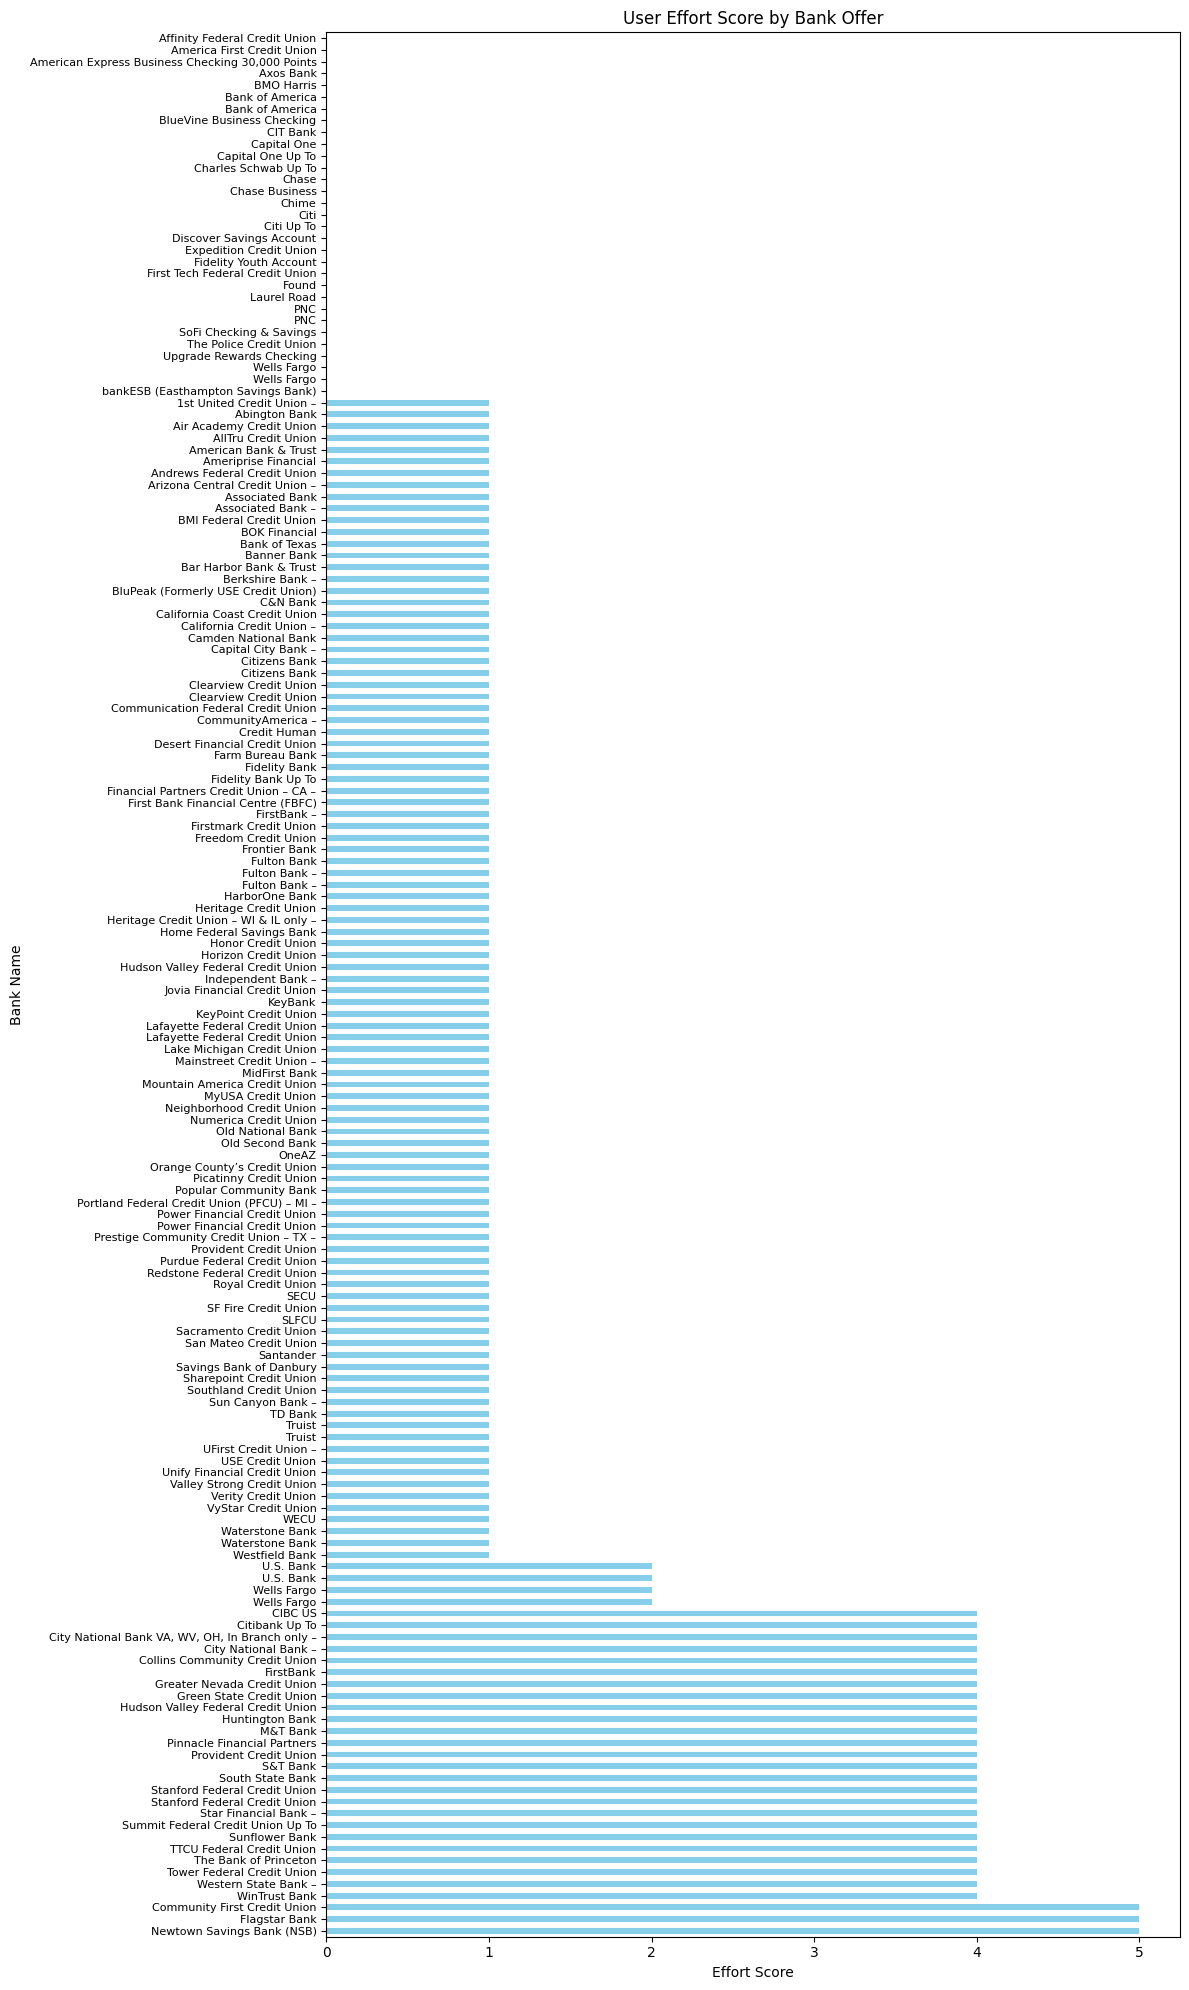

In [21]:
# Visualizations

# Clean dataset
df_clean = df.dropna(subset=['Bank Name'])
df_clean['Bank Name'] = df_clean['Bank Name'].astype(str).str.strip()
df_clean = df_clean[df_clean['Bank Name'] != '']

# Dynamic height
num_banks = df_clean.shape[0]
height = max(6, min(0.25 * num_banks, 20))

# Sort + plot with pandas plot (better label alignment)
plt.figure(figsize=(12, height))
df_clean.sort_values(['UserEffortScore', 'Bank Name'], ascending=[False, False]).plot(
    kind='barh',
    x='Bank Name',
    y='UserEffortScore',
    legend=False,
    color='skyblue',
    ax=plt.gca()
)
plt.xlabel('Effort Score')
plt.title('User Effort Score by Bank Offer')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


Cybersecurity Awareness

Churning increases personal attack surface: multiple bank logins, sensitive data, online banking. I mitigate these risks by:
- Using a password manager
- Enabling 2FA everywhere
- Keeping personal and business accounts separate
- Regularly monitoring accounts for fraud

This aligns with Networking & Cybersecurity coursework: CIDM 6356 + CIDM 6340.

Next steps:
- Add more real offers from other sources
- Expand advisor logic (more factors, pull data from Gemini's AI response in .csv data file)
- Develop seed fund optimizer